# Lab  7 - Bayesian inference with PyMC3.

##### Keywords: bioassay, hierarchical, binomial regression, regression, gewecke, gelman-rubin

## Learning Aims

- Using PyMC3
- Building probability models
- MAP estimates with PyMC3
- Sampling with PyMC3
- Convergence tests
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn.apionly as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time

# A few words about PyMC3

PyMC3 is an open source probabilistic programming tool that uses a very natural syntax. It features state-of-the-art MCMC sampling methods such as the No-U-Turn-Sampler (NUTS) and Hamiltonian Monte Carlo (HMC). PyMC3 uses Theano to perform authomatic differentiation, which makes it very efficient in calculating the gradients used in these methods. In this lab we will be using PyMC3 to make inference for the bioassay experiment.  We blatantly steal some text and ideas from fonnesbeck's notebooks for bioinformatics. We also use material from the PyMC3 official tutorials: http://pymc-devs.github.io/pymc3/notebooks/getting_started.html

The idea behind PyMC3 is to make Bayesian inference and sampling as simple as possible. Some of the features of PyMC3 are:

* Fits Bayesian statistical models with Markov chain Monte Carlo, variational inference and other algorithms.
* Includes a large suite of well-documented statistical distributions.
* Creates summaries including tables and plots.
* Traces can be saved to the disk as plain text, SQLite or pandas dataframes.
* Several convergence diagnostics and model checking methods are available.
* Extensible: easily incorporates custom step methods and unusual probability distributions.
* MCMC loops can be embedded in larger programs, and results can be analyzed with the full power of Python.

# Bioassay experiment

This code follows an example from Gelman's "Bayesian Data Analysis".

We demonstrate this with an example and examine the convergence of the resulting samples. 

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment, various drug doses are administered to animals and a binary outcome (death) is noted. There are 4 groups of 5 animals each, different doses administered, and deaths recorded. We construct a model for $\theta$ the binomial probabiliy of death, as a regression on dose through the logit$^{-1}$ function with two parameters (see below). We set imprecise normal priors on the regression coefficients, and pass the linear regression through the inverse logit function into a binomial likelihood.

Let us enter these data:

In [2]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

# Log dose in each group
log_dose = np.array([-.86, -.3, -.05, .73])

# Let's make this a theano shared variable so that we can make predictions for new values later
log_dose_shared = shared(log_dose)

# Sample size in each group
n = 5 * np.ones(4, dtype=int)

# The sample size has to be a shared variable too
n_shared = shared(n)

# Outcomes
deaths = np.array([0, 1, 3, 5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$

We can first calculate this posterior by frute force (assuming uniform priors), and also plot some of the inverse logistic as a function of different $\alpha$ and $\beta$ values in order to have some intuition about the model:

In [3]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=deaths, x=log_dose):
    # Calculate joint posterior, given values for a, b 
    # x: dosage
    # y: number of deaths
    # a + b: parameters of the model
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

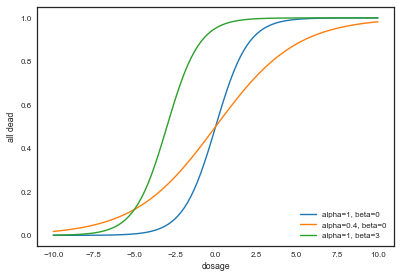

In [4]:
# some intuition about this model
xx = np.linspace(-10,10,100)
plt.plot(xx, logitInv(xx), label="alpha=1, beta=0")
plt.plot(xx, logitInv(0.4*xx), label="alpha=0.4, beta=0")
plt.plot(xx, logitInv(xx+3), label="alpha=1, beta=3")
plt.xlabel("dosage")
plt.ylabel("all dead")
plt.legend(loc=4)

We see that for a given dosage, different values of $\alpha$ and $\beta$ can yield very different death rates. Now let us plot the posterior probability as a function of these two parameters:

In [5]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101) # alpha
X2 = np.linspace(-10, 30,100) # beta
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1

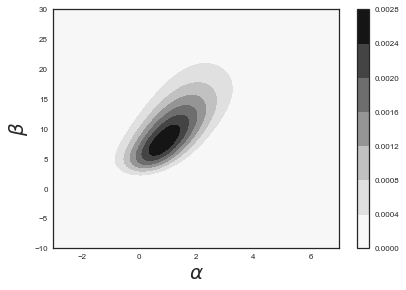

In [6]:
# look at the posterior distribution
plt.contourf(X1,X2,pp.T)
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)
plt.colorbar()

## Setting up the model in PyMC3

The first step is to specify the probabilistic model in PyMC3. A probabilistic model relates unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: stochastic random variables and deterministic variables. A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. Typically, after instantiating our model object, we first set up the priors, then we write expressions for the deterministic variables, and finally we write the data likelihood as a function of the variables:

In [7]:
from pymc3 import Normal, Binomial, sample, Model # Import relevant distributions
from pymc3.math import invlogit

with Model() as bioassay_model:

    # Logit-linear model parameters
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)

    # Calculate probabilities of death
    theta = invlogit(alpha + beta * log_dose_shared)

    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

At the model-specification stage (before the data are observed), $\alpha$, $\beta$, $\theta$, and $y$ (the observed number of deaths) are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. 

The only deterministic variable in this model is $\theta$. If we knew the values of $\theta$'s parents ($\alpha$ and $\beta$), we could compute the value of $\theta$ exactly. A deterministic like $\theta$ is defined by a mathematical function that returns its value given values for its parents. On the other hand, even if the values of the parents of variables $\alpha$, $\beta$ and $y$ (before observing the data) were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

Using the model we have specified above, we can now do a number of things. For example, we can obtain maximum a posteriori (MAP) point estimate for the parameters. But we want to know about the uncertainties of these parameters, and we can only get that information by getting samples from the posterior (assuming we can not solve this analytically). Therefore, we can obtain samples from the posterior using PyMC3's ```sample``` function. It will fit probability models (linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this):

### Finding MAP point estimates
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the ```find_MAP```  function.

In [8]:
# Obtain a MAP point estimate
from pymc3 import find_MAP

map_estimate = find_MAP(model=bioassay_model)

print(map_estimate)


logp = -13.034, ||grad|| = 0.00043389: 100%|██████████| 14/14 [00:00<00:00, 116.68it/s] 


{'alpha': array(0.8437566864565978), 'beta': array(7.730204614414374)}


By default, ```find_MAP``` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm (an approximation of Newton's method that approximates the Hessian and assumes expands the function as a Taylor expansion) to find the maximum of the log-posterior, but also allows selection of other optimization algorithms from the ```scipy.optimize``` module. For example, below we use Powell’s method to find the MAP.

In [9]:
# Obtain a MAP point estimate with Powell's method
from scipy import optimize

map_estimate = find_MAP(model=bioassay_model, fmin=optimize.fmin_powell)

print(map_estimate)


//anaconda/envs/py3l/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -13.107:   2%|▏         | 79/5000 [00:00<00:02, 2233.22it/s]

Optimization terminated successfully.
         Current function value: 13.033671
         Iterations: 3
         Function evaluations: 79
{'alpha': array(0.8409685695516148), 'beta': array(7.724974670803666)}


In Powell's method we move along one orthogonal base direction at at time, needing to minimize only in one dimension, using methods that do not require a derivative to be calculated.

### Sampling

We can now sample using the ```sample``` function, to which we can optionally pass a step method and a starting value, than can naturally be one of our MAP point estimates.

In [10]:
from pymc3 import find_MAP

with bioassay_model:
    
    # obtain starting values via MAP
    start = find_MAP(model=bioassay_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # draw 2000 posterior samples
    bioassay_trace = sample(50000, step=step, start=start)


#with bioassay_model:
#    bioassay_trace = sample(1000)

logp = -13.034, ||grad|| = 0.00043389: 100%|██████████| 14/14 [00:00<00:00, 1820.33it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 50500/50500 [00:14<00:00, 3583.68it/s]
The number of effective samples is smaller than 10% for some parameters.


The first argument of ```sample``` is the number of samples to be drawn. Note that we have also used something called ```step``` as an argument. This refers to the MCMC method that we will use. Possible choices are Metropolis, slice sampling, HMC and NUTS algorithms. For this lab we will stick to the Metropolis and NUTS steps. Interestingly, by using the ```step``` argument, we can use the MAP estimate that we have used as the starting point for the MCMCM sampling.

After we run the model, the chain of draws from it will be stored in a data structure called ```trace```. We can access the trace and plot it, as well as the smoothed histograms of the parameters. In this case, we just sample the last half of the samples, the first half is our burnin period:

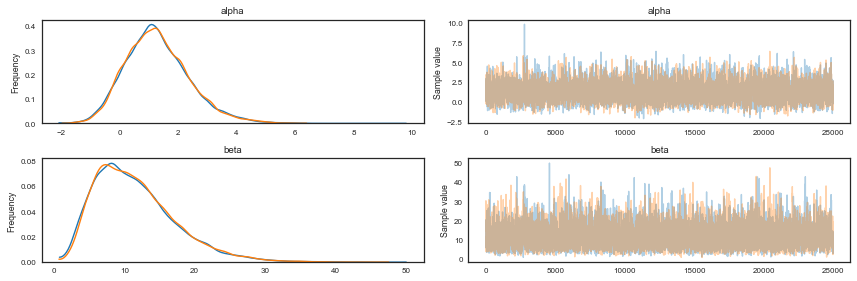

In [11]:
from pymc3 import traceplot

#traceplot(bioassay_trace[500:], varnames=['alpha'])
traceplot(bioassay_trace[25000:])
tr1 = bioassay_trace[25000:]

We can also plot the 2D posterior and compare with the analytical plot above.

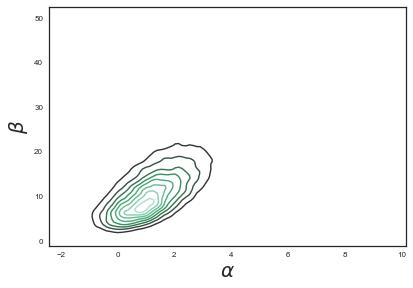

In [12]:
sns.kdeplot(bioassay_trace['alpha'][25000:], bioassay_trace['beta'][25000:])
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)

We can print a summary for our variables:

In [13]:
from pymc3 import summary

summary(tr1, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.309900,1.086593,0.016202,-0.821303,3.40299,3967.0,0.999980
beta,11.585306,5.742244,0.093417,2.642882,23.06583,3659.0,0.999983


And look for autocorrelations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b71c8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12056a5c0>]], dtype=object)

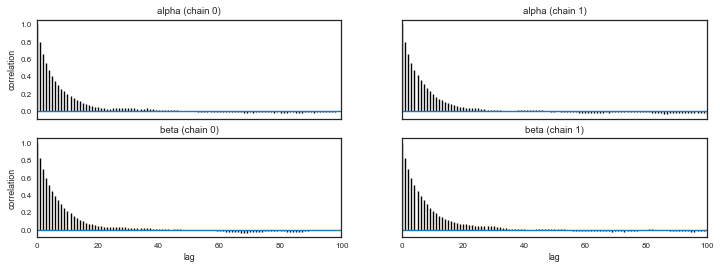

In [21]:
from pymc3 import autocorrplot
autocorrplot(tr1)

## Model checking

After we have obtained the samples, we need to perform model checking in order to ensure that the inferences we have derived from the sampling are actually valid. Model checking consists of two parts: 1) Convergence diagnostics and 2) goodness of the fit.

It is in general impossible to guarantee that a MCMC has indeed reached convergenge,  but convergence diagnostics can detect lack of convergence. Model checking allows us to check the internal validity of the model by comparing predictions of the model with data used to fit it (i.e. posterior predictive issues).

### Convergence diagnostics

An informal approach involves plotting a histogram for every set of $k$ iterations (perhaps 50-100) beyond some burn in threshold $n$; if the histograms are not visibly different among the sample intervals, this may be considered some evidence for convergence. Note that such diagnostics should be carried out for each stochastic estimated by the MCMC algorithm, because convergent behavior by one variable does not imply evidence for convergence for other variables in the analysis.

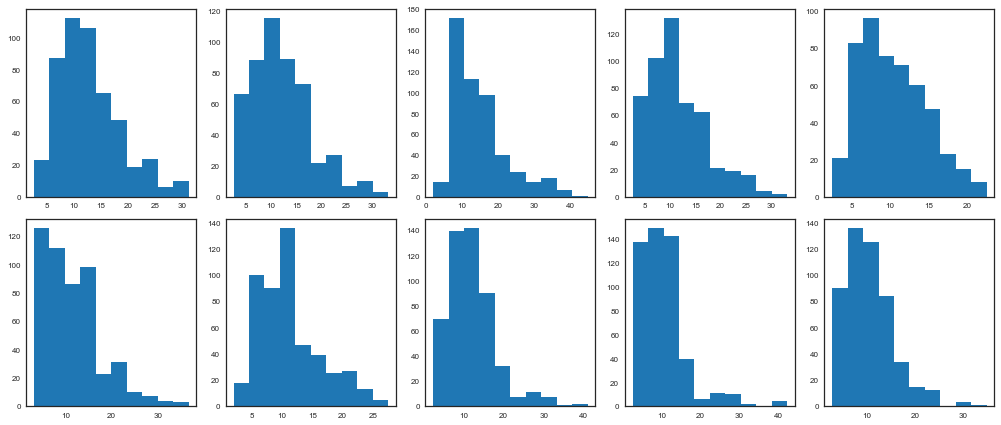

In [14]:
beta_trace = bioassay_trace['beta']

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(beta_trace[500*i:500*(i+1)])
plt.tight_layout()

Another *ad hoc* method to detect lack of convergence involves plotting the traces of chains initialized with different starting conditions. We can run more than one chain using the argument ```njobs``` of the  ```sample``` function. If convergence has occurred, we would expect the two chains to converge to the same value, and to have approximately the same variance. This convergence to the same equilibrium state is what we call *ergodicity*, but its fullfilment it is not guaranteed by these heuristic methods, since the chain can be in a state of *metastability* and reian there for a large number of iterations before moving to a more stable state.

In [20]:
with bioassay_model:
    step = pm.Metropolis()
    bioassay_trace1 = sample(50000, njobs=4, step=step, start=[{'alpha':0.5}, {'alpha':5}, {'alpha':1.5}, {'alpha':3}])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 50500/50500 [00:25<00:00, 1956.08it/s]
The number of effective samples is smaller than 10% for some parameters.


In [22]:
pm.effective_n(bioassay_trace1)

{'alpha': 15792.0, 'beta': 14255.0}

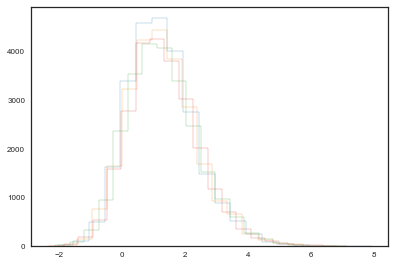

In [24]:
plt.hist(bioassay_trace1.get_values('alpha', chains=0)[25000:], histtype="step", bins=20)
plt.hist(bioassay_trace1.get_values('alpha', chains=1)[25000:], histtype="step", bins=20)
plt.hist(bioassay_trace1.get_values('alpha', chains=2)[25000:], histtype="step", bins=20)
plt.hist(bioassay_trace1.get_values('alpha', chains=3)[25000:], histtype="step", bins=20);

### Formal methods

### 1. Geweke

The Geweke test (Geweke, 1992) is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{Var(\theta_a)+Var(\theta_B)}}$$

where $a$ is the early interval and $b$ the late interval. If the z-scores (theoretically distributed as standard normal variates) of these two segments are similar, it can provide evidence for convergence. PyMC calculates z-scores of the difference between various initial segments along the chain, and the last 50% of the remaining chain. If the chain has converged, the majority of points should fall within 2 standard deviations of zero.
In PyMC, diagnostic z-scores can be obtained by calling the *geweke* function. It accepts either (1) a single trace, (2) a Node or Stochastic object, or (4) an entire Model object:

In [25]:
from pymc3 import geweke
    
z = geweke(tr1, intervals=15)

(0, 13000)

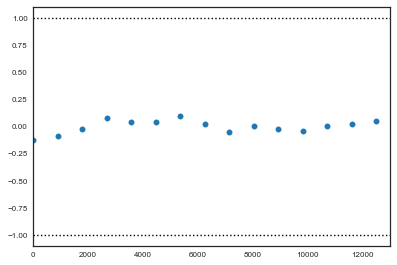

In [28]:
plt.scatter(*z[0]['alpha'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

(0, 13000)

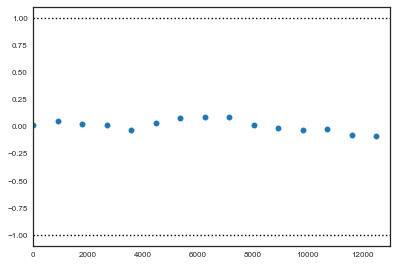

In [32]:
plt.scatter(*z[1]['alpha'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

### 2. Gelman-Rubin

This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.
The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. That is, it calculates both the between-chain varaince (B) and within-chain varaince (W), and assesses whether they are different enough to worry about convergence. Assuming $m$ chains, each of length $n$, quantities are calculated by:

$$
\begin{align}B = \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W = \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}
$$
for each scalar estimand $\theta$. Using these values, an estimate of the marginal posterior variance of $\theta$ can be calculated:

$$
\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B
$$

Assuming $\theta$ was initialized to arbitrary starting points in each chain, this quantity will overestimate the true marginal posterior variance. At the same time, $W$ will tend to underestimate the within-chain variance early in the sampling run. However, in the limit as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$. In light of this, the Gelman-Rubin statistic monitors convergence using the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of the potential reduction in the scale of $\theta$ as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$ close to one (say, less than 1.1) to be confident that a particular estimand has converged. In PyMC, the function gelman_rubin will calculate $\hat{R}$ for each stochastic node in the passed model:

In [33]:
from pymc3 import gelman_rubin

gelman_rubin(bioassay_trace1)

{'alpha': 1.0001396613551423, 'beta': 1.0001433985689452}

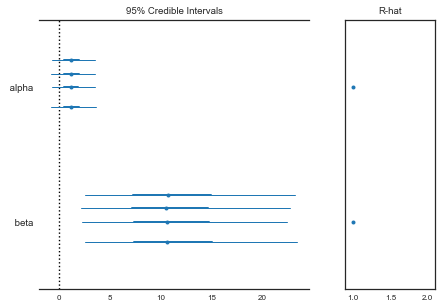

In [34]:
from pymc3 import forestplot

forestplot(bioassay_trace1)

### Goodness of fit: posterior predictive

The posterior predictive is the distribution of unobserved data conditioned on the observed data. It is constructed by averaging the likelihood of new unseen datapoints over all possible parameter values, weighted by their posterior probability:

$$
p(\tilde{y}|y) = \int p(\tilde{y}|\theta) p(\theta|y) d\theta
$$

This is: the probability of observing an hypotetical new datapoint given the observed data equals the likelihood of the datapoint given the model parameters, times the probability of that particular choice of parameters, marginalized over all possible parameter values.

We would expect that the posterior predictive distribution is indistinguishable from the actual observed distribution of datapoints. It is easy to sample from the posterior predictive in PyMC3:

In [35]:
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1786.86it/s]


If the model fit is good, we would expect the observed true data to fall within a region of high probability of the posterior predictive distribution. Otherwise, if the fit is not so good, we would expect to see the observed true data in the tails if the posterior predictive. Let us plot and see:

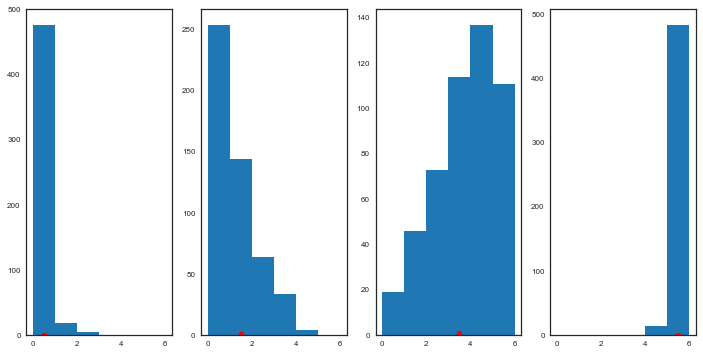

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for obs, sim, ax in zip(deaths, deaths_sim['obs_deaths'].T, axes):
    ax.hist(sim, bins=range(7))
    ax.plot(obs+0.5, 1, 'ro')

But of course, what we want is being able to predict new observations. We can create an array of new hypothetical doses:

In [37]:
log_dose_to_predict = np.random.uniform(-0.8,0.7,size=50)
#log_dose_to_predict =  np.array([-0.5])
log_dose_to_predict
n_predict = n = 5 * np.ones(50, dtype=int)

We now update the values of the shared variable we have created with the values for which we want to predict:

In [38]:
# Changing values here will also change values in the model
log_dose_shared.set_value(log_dose_to_predict)
n_shared.set_value(n_predict)

In [39]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 2511.72it/s]


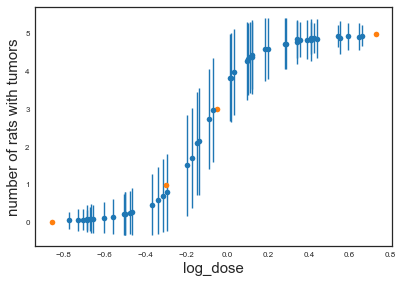

In [40]:
plt.errorbar(x=log_dose_to_predict, y=np.asarray(ppc['obs_deaths']).mean(axis=0), yerr=np.asarray(ppc['obs_deaths']).std(axis=0), linestyle='', marker='o')
plt.plot(log_dose, deaths, 'o')
plt.xlabel('log_dose',size=15)
plt.ylabel('number of rats with tumors',size=15)

The posterior predictives give us something nice: uncertainties in our predcictions.